# Vechicle Detection

* Explore Data
* Feature extraction
* Training Classifier
* scroll window to analysis image

## Explore Data


In [64]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import random
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time
from scipy.ndimage.measurements import label

#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles

def load_files(start_dir,files,suffix):
    for dr,_,_ in os.walk(start_dir):
        files.extend(glob.glob(os.path.join(dr,suffix)))        
    return files

def load_data(start_path,suffix='*.png'):
    files=[]
    imgs=[]
    suffix='*.png'
    files=load_files(start_path,files,suffix)
    for filename in files:
        imgs.append(cv2.imread(filename))
    return files,imgs

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    
    test_image = car_list[0]
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape 
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype
    # Return data_dict
    
    return data_dict

In [65]:
def display_image(img, title):
    plt.title(title)
    plt.imshow(img)
    plt.show()

In [66]:
def load_dataset():
    cars,cars_images=load_data('data/vehicles')
    notcars,notcars_images=load_data('data/non-vehicles')
    print(len(cars_images))
    print(len(notcars_images))
    return cars,cars_images,notcars,notcars_images

#load_data('data/vehicles_smallset/cars1','.jpeg')
#load_data('data/non-vehicles_smallset/notcars1','.jpeg')

In [67]:
cars,cars_images,notcars,notcars_images=load_dataset()
data_info=data_look(cars_images,notcars_images)

8792
8968


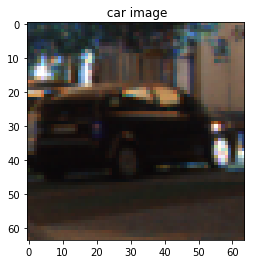

In [68]:
display_image(cars_images[random.randint(0, data_info['n_cars'])], ' car image')


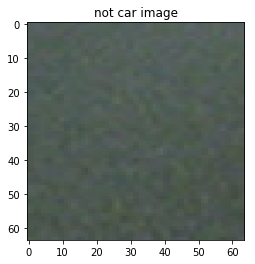

In [69]:
display_image(notcars_images[random.randint(0, data_info['n_notcars'])], 'not car image')


# Color Histogram


In [70]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# HOG Classify

In [71]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Combine Different feature together

In [72]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        img = mpimg.imread(file)
        img_features=single_img_features(img, color_space, spatial_size,
                                         hist_bins, orient,pix_per_cell, cell_per_block, hog_channel,
                                         spatial_feat, hist_feat, hog_feat)
        img_features_inv=single_img_features(np.fliplr(img), color_space, spatial_size,
                                             hist_bins, orient,pix_per_cell, cell_per_block, hog_channel,
                                             spatial_feat, hist_feat, hog_feat)

        features.append(img_features)
        features.append(img_features_inv)
    # Return list of feature vectors
    return features



In [73]:
len(notcars)

8968

# Train Classifier



In [74]:
sample_size = 1700
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler

X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using the folowing parameters')
print('  orientations:',orient)
print('  pixels per cell:',pix_per_cell)
print('  cells per block:',cell_per_block )
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using the folowing parameters
  orientations: 9
  pixels per cell: 8
  cells per block: 2
0.88 Seconds to train SVC...
Test Accuracy of SVC =  0.9853


In [75]:
svc

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [76]:
import pickle
data = {
        'scaler': X_scaler,
        'classifier': svc
        }

with open('classifier.p', 'wb') as f:
    pickle.dump(data, f)

In [77]:
car_features[0].shape

(2580,)

In [78]:
PIX_PER_CELL = 8 # HOG pixels per cell
CELL_PER_BLOCK = 2 # HOG cells per block


# Scroll image and search car

In [124]:
def stride_windows(img, win_size, num_win_x, y_top):
    x_right = img.shape[1] - win_size
    x_offset=400
    x_stride = int(round((x_right-x_offset) / (num_win_x-1)))
    windows = []
    for xs in range(num_win_x-1):
        windows.append(((xs*x_stride+x_offset, y_top), (xs*x_stride+win_size+x_offset, y_top+win_size)))
    # Make sure that the last window is pushed all the way to the edge
    windows.append(((x_right, y_top),(img.shape[1], y_top+win_size)))
    return windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    colors = [(0, 0, 255), (0, 255, 0)]
    for idx, bbox in enumerate(bboxes):
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], colors[idx%2], thick)
    # Return the image copy with boxes drawn
    return imcopy

def form_windows(image):
    windows = []
    coords = [
        (75, 40, 400),
        (120, 30, 390),
        (200, 10, 390),
        (220, 30, 350),
    ]
    for win_size, num_win_x, y_top in coords:
        windows.extend(stride_windows(image, win_size, num_win_x, y_top))
    return windows



# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list

    for window in windows:
        #img = img.astype(np.float32)/255

        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
     
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


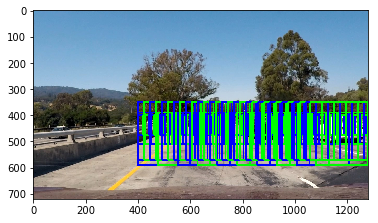

In [125]:
imagename = 'test_images/test1.jpg'

img = mpimg.imread(imagename)
windows = form_windows(img)
window_img = draw_boxes(img, windows, color=(0, 0, 255), thick=6) 
        # Convert to uint8 so that imshow displays properly
plt.imshow(window_img.astype(np.uint8))

plt.show()

In [126]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def get_labels(heatmap_img):
    return label(heatmap_img)

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
2


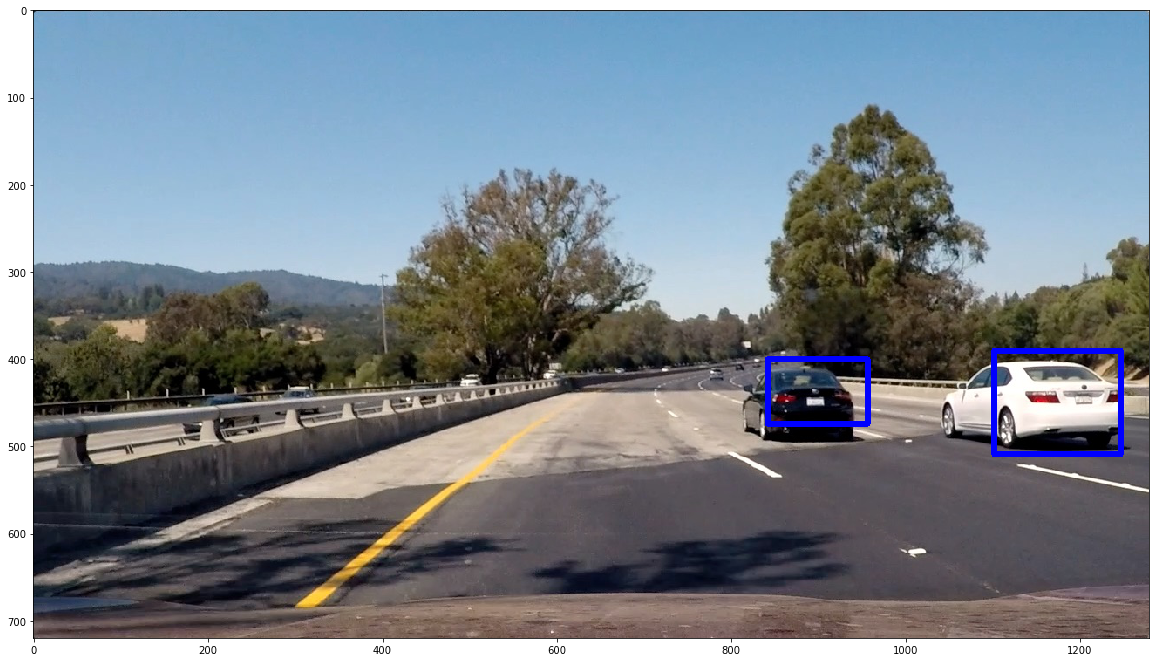

In [127]:

image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
#window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
print(labels)
print(labels[0])
print(labels[1])

draw_img = draw_labeled_bboxes(np.copy(image), labels)
plt.figure(figsize=(20, 20))
plt.imshow(draw_img)
plt.show()

# pipeline

In [128]:
def pipeline(image, return_heatmap=False):
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float)/255.0


    windows = form_windows(image)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

                    

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image)*255, labels)
    if return_heatmap:
        return draw_img, heatmap
    return draw_img


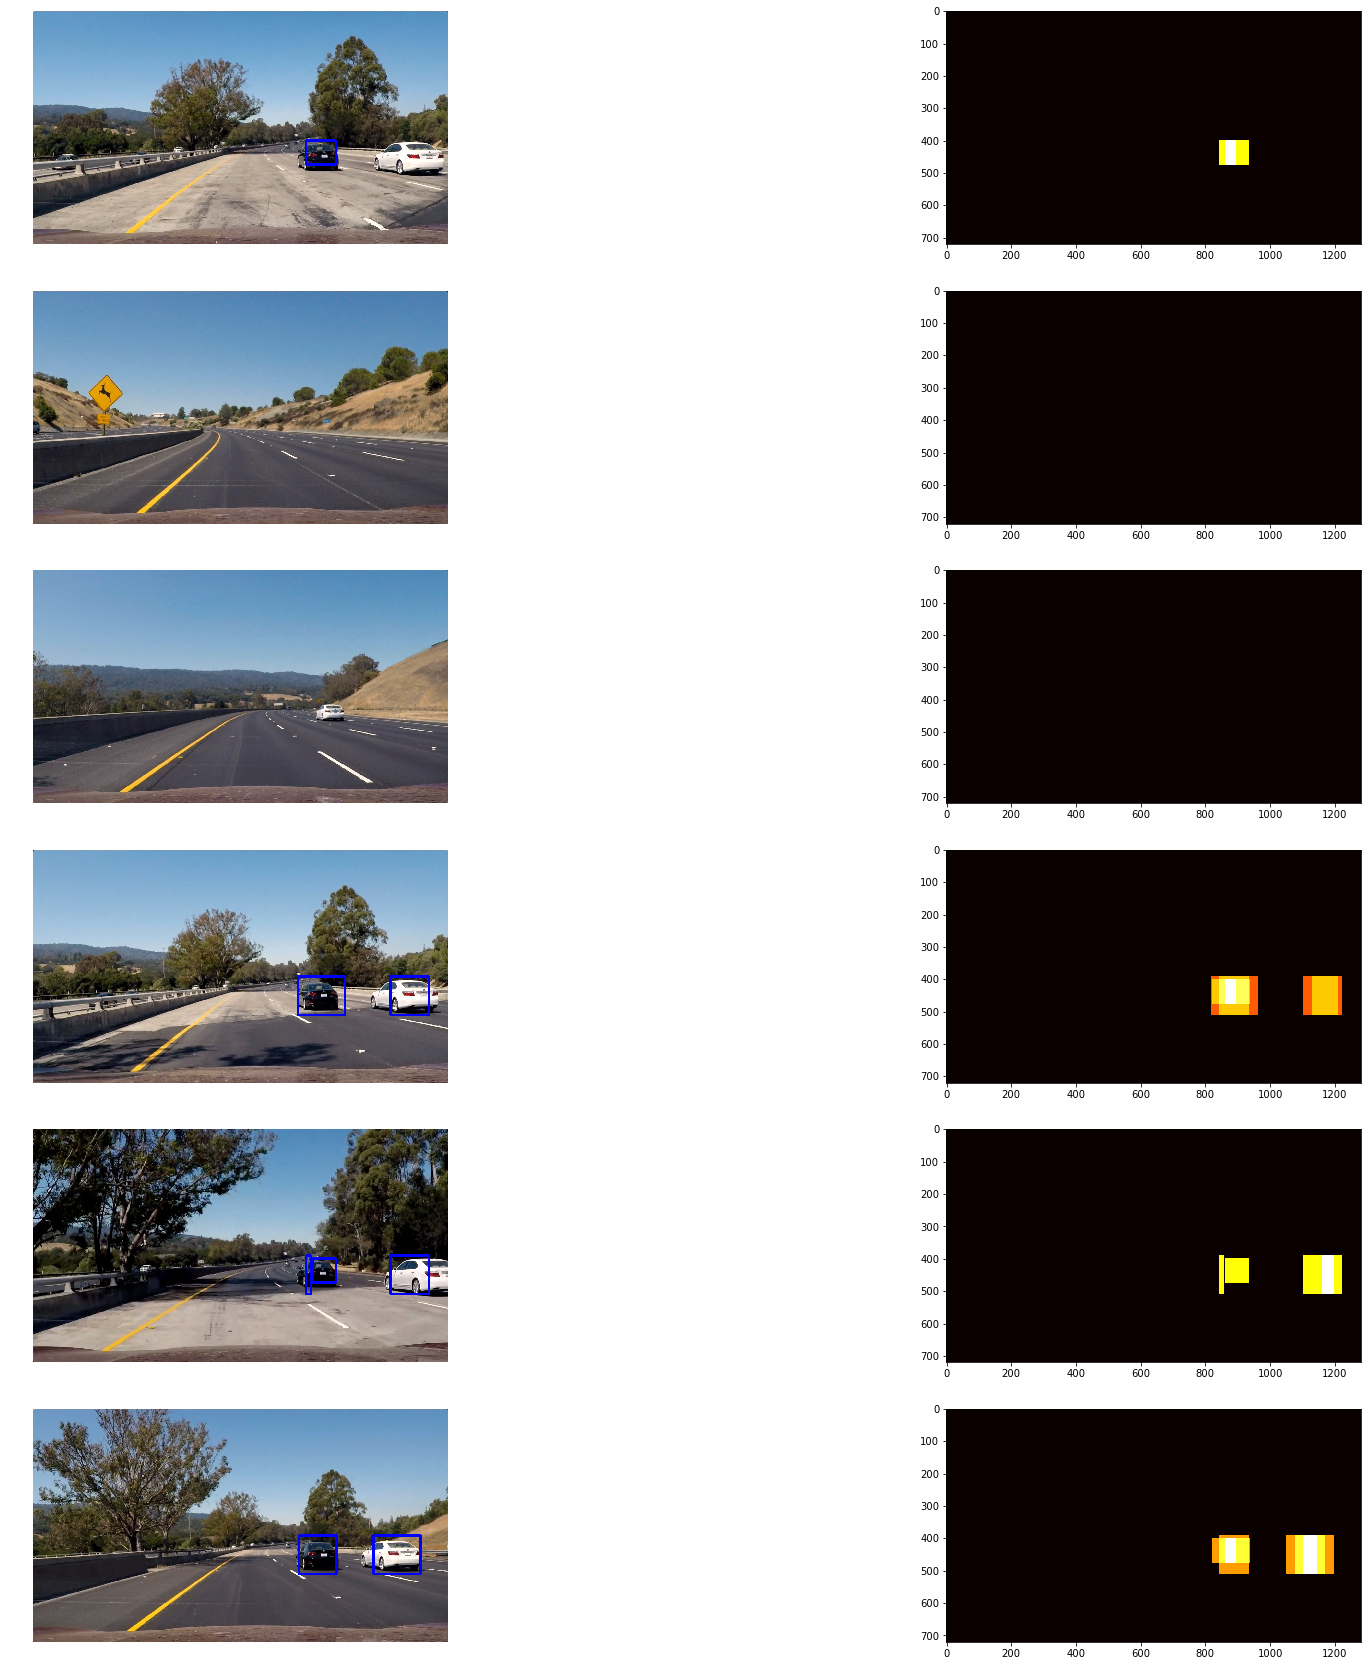

In [129]:
images = glob.glob('test_images/test*.jpg')
fig, axs = plt.subplots(len(images), 2, figsize=(30,30))
cnt = 0
for cnt, ax in enumerate(axs):
    img = mpimg.imread(images[cnt])
    draw_img, heatmap = pipeline(img, True)
    # Convert to uint8 so that imshow displays properly
    ax[0].imshow(draw_img.astype(np.uint8))
    ax[0].axis('off')
    ax[1].imshow(heatmap, cmap='hot')
plt.show()

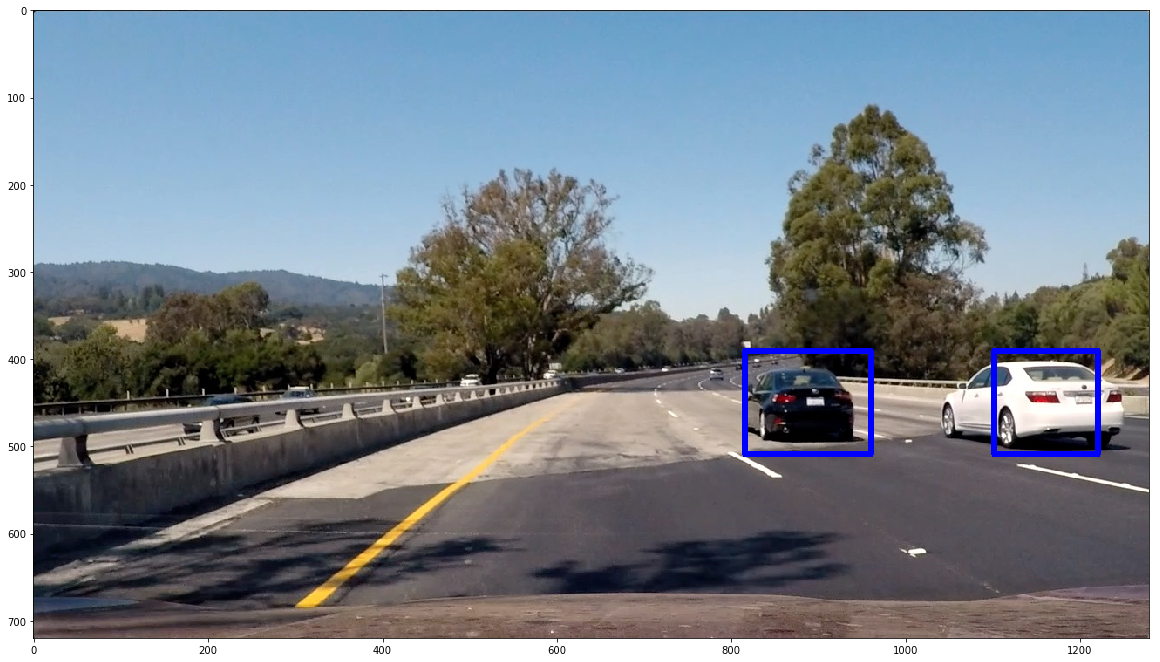

In [130]:


draw_img,heatmap = pipeline(image, True)
fig=plt.figure(figsize=(20,20))
plt.imshow(draw_img.astype(np.uint8))
plt.show()


# Video Handle

In [131]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
bVideo=True
white_output = 'p5_processed_video_project.mp4'

clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(lambda img: pipeline(img,False))
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video p5_processed_video_project.mp4
[MoviePy] Writing video p5_processed_video_project.mp4


100%|█████████▉| 1260/1261 [05:35<00:00,  4.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: p5_processed_video_project.mp4 

CPU times: user 5min 14s, sys: 24.9 s, total: 5min 39s
Wall time: 5min 35s


In [132]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))